# Algorithm for segmentation variability estimation 

The algorithm consists of three steps: The first step estimates the quality of the segmentation input via intensity prior. The second step identifies sets of segments within segmentation contour of low quality value. The third and final step computes the sensitivity of each low quality segment and its associated variability region. 

In [10]:
# some setup
import numpy as np
import nibabel as nib
import scipy.ndimage.filters
from scipy import ndimage
import os 
import matplotlib.pyplot as plt
from math import *
from PIL import Image

### let's begin:
1. Choose two _.NIfTI_ files: volume and groud truth. <br>
2. Assign data_path to the directory path. <br>
3. Assign idx to view the desired silce. <br>

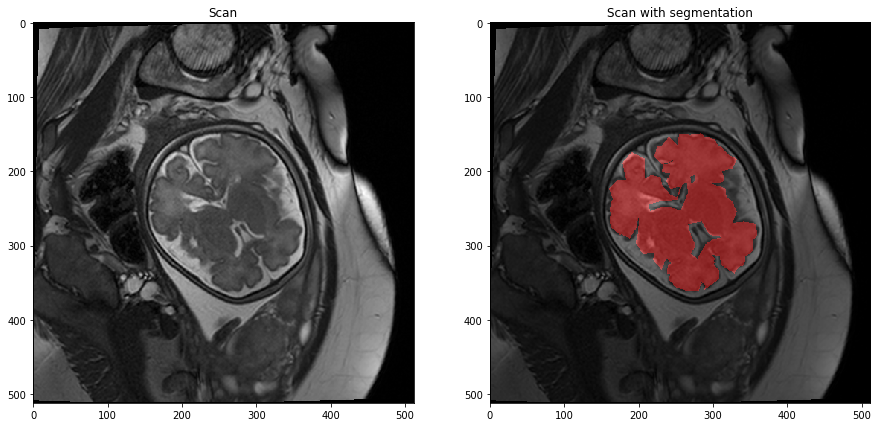

In [11]:
data_path = '/home/bella/Phd/data/brain/TRUFI_axial_siemens/19' #19
example_filename = os.path.join(data_path, 'volume.nii') 
img = nib.load(example_filename)
img_data = img.get_fdata()
idx = 11
slice_normal = img_data[ :, :,idx]

truth_path = os.path.join(data_path, 'truth.nii') 
truth_img = nib.load(truth_path)
truth_data = truth_img.get_fdata()
slice_truth = truth_data[ :, :,idx]

def overlay_image_mask(img, mask, mask2 = None):    
    img *= 255.0/img.max()
    img = Image.fromarray(img.astype(np.uint8)).convert("RGBA")
    gt_np = np.zeros([mask.shape[0], mask.shape[1],3], dtype=np.uint8)
    gt_np[:,:,0] = (mask.astype(np.uint8))*255
    if mask2 is not None:
        gt_np[:,:,1] = (mask2.astype(np.uint8))*255
    gt = Image.fromarray(gt_np).convert("RGBA")
    return Image.blend(img, gt, 0.4)


plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
plt.title('Scan')
plt.imshow(slice_normal, 'gray', interpolation='none')

plt.subplot(1,2,2)
plt.title('Scan with segmentation')
pil_im = overlay_image_mask(slice_normal, slice_truth)
plt.imshow(np.asarray(pil_im))

plt.show()

__figure 1__ : original scan and segmentation.

In [12]:
def get_contour(img):
    sx = ndimage.sobel(img,axis=0,mode='constant')
    sy = ndimage.sobel(img,axis=1,mode='constant')
    sobel=np.hypot(sx,sy)
    sobel[sobel > 0 ]=1
    return sobel

In [4]:
k = 1/16
sobel_x = k*np.array([[1,1,1,0,1,1,1],[1,2,2,0,-2,-2,-1],[1,2,3,0,-3,-2,-1],[1,2,3,0,-3,-2,-1],
                    [1,2,3,0,-3,-2,-1],[1,2,2,0,-2,-2,-1],[1,1,1,0,1,1,1]])
sobel_y = k*np.array([[-1,-1,-1,-2,-1,-1,-1],[-1,-1,-1,-2,-1,-1,-1],[-1,-1,-1,-2,-1,-1,-1],[0,0,0,0,0,0,0],
                    [1,1,1,2,1,1,1],[1,1,1,2,1,1,1],[1,1,1,2,1,1,1]])

### _Step 1 – Segmentation quality estimation_

The segmentation quality is estimated using the input segmentation priors:

#### intensity prior:
_Let_ $s$ =$<$ $p_1$,…,$p_n$ $>$ be a segmentation contour of a structure of interest $O$ in image $I$. A prior defines a quality vector $qv$ $\in$ $[0,1]^k$ such that $qv(i)$ is the quality value for point $p_i$. We denote the _Intensity_ _Prior_ as $P_{intensity}$ $(s,I)$ and define it as:


\begin{cases}
  P_{intensity} = 1 & \text{for } |\nabla I(p_i)| >w\sigma \\    
  P_{intensity} =  \frac{|\nabla I(p_i)|}{w\sigma}    
\end{cases}

where $\nabla I(p_i)$ is the image gradient on point $p_i$, $\sigma$  is the image gray values standard deviation of the pixels in the segmentation contour $s$ and w is a weighting parameter used to control the influence of the prior. $w = 1.5$ and the kernel size is $7\times7$:

In [13]:
def intensity_prior(img, contur): # per slice
    k = 1/16
 #   w = 1.5 #weighting parameter
    w = 2 #weighting parameter
    # sobel_x = k*np.array([[1,1,1,0,1,1,1],[1,2,2,0,-2,-2,-1],[1,2,3,0,-3,-2,-1],[1,2,3,0,-3,-2,-1],
    #                     [1,2,3,0,-3,-2,-1],[1,2,2,0,-2,-2,-1],[1,1,1,0,1,1,1]])
    # sobel_y = k*np.array([[-1,-1,-1,-2,-1,-1,-1],[-1,-1,-1,-2,-1,-1,-1],[-1,-1,-1,-2,-1,-1,-1],[0,0,0,0,0,0,0],
    #                     [1,1,1,2,1,1,1],[1,1,1,2,1,1,1],[1,1,1,2,1,1,1]])
    sx = ndimage.sobel(img,axis=0,mode='constant')
    sy = ndimage.sobel(img,axis=1,mode='constant')
    sp_intensity = np.zeros(img.shape)
    sp_intensity[contur==1]=1

    sigma = np.std(img[contur==1])
    c_points = np.argwhere(contur == 1)
    # get gradients:
    for i in range(len(c_points)):
        y, x = c_points[i]
     #   sub = img[y-3:y+4,x-3:x+4]
        grad_x = np.average(sx[y-3:y+4,x-3:x+4])
        grad_y = np.average(sy[y-3:y+4,x-3:x+4])
        grad_tot = (grad_x**2 + grad_y**2)**0.5
        if abs(grad_tot)<= sigma*w:
            sp_intensity[y,x] = abs(grad_tot)/(sigma*w)
        else:
            sp_intensity[y,x] = 1
    return sp_intensity

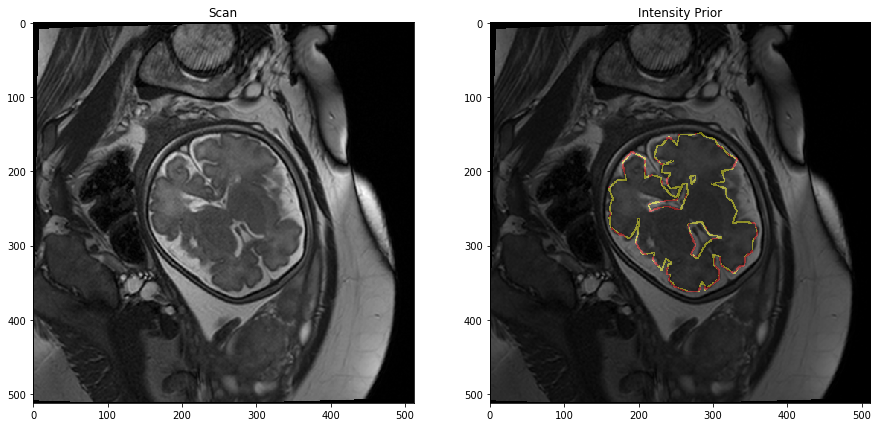

In [14]:
cont = get_contour(slice_truth)
res_ints = intensity_prior(slice_normal, cont)


low_quality = np.zeros(slice_normal.shape)
low_quality[res_ints < 1] = 1
low_quality[res_ints == 0] = 0

plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
plt.title('Scan')
plt.imshow(slice_normal, 'gray', interpolation='none')

plt.subplot(1,2,2)
plt.title('Intensity Prior')
pil_im = overlay_image_mask(slice_normal,cont,low_quality)
plt.imshow(np.asarray(pil_im))

plt.show()

__figure 2__: The scan and the intensity prior, yellow areas denote a low intensity prior i.e a low segmentation quality

### _Step 2 - Identification of low quality segmentation segments_

This step computes a set of mutually disjoint segments on a segmentation contour whose points have a low quality value. The two stop criteria  per segment are:<br>

1) The changes in the quality values along the contour:<br> _Let_ $s$ =$<$ $p_1$,…,$p_n$ $>$ be a segmentation contour, a segment is defind as $r(s, p_i, p_j) = <p_i,p_{i+1}...,p_j>$ and is considered a low quality segment if the maximum quality of its defining points is smaller than a given threshold: $T_{quality}$.<br>

2) Sharp angular change of the _Segment Direction_ greater than the threshold $T_{direction}$. The Segment Direction is the mean direction of its points: $SD(r(s, p_i, p_j)) = $ $\frac{1}{j-i}$ $\sum_{t=i+1}^{j}$ $tan^{-1}$($\frac{y_t - y_{t-1}}{x_t - x_{t-1}}$)


In [7]:
T_length = 5
T_quality = 0.7
T_direction = np.pi/6
eps = 0.05

def get_intervals(img, contour):
    R = []
    R_arr = np.zeros(img.shape)
    pts = np.argwhere(contour==1)
    intensity_pr = intensity_prior(img, contour)
    direction = []
    visited = [False]*(len(pts))
    for i in range(len(pts)):
        curr = []
        deg = 0
        y,x = pts[i]
        if not visited[i] and intensity_pr[y,x] < T_quality:
            visited[i] == True
            for j in range(1,T_length):
                if i+j < len(visited):
                    visited[i+j] = True
                    y_2, x_2 = pts[i+j]
                    y_1, x_1 = pts[i+j-1]
                    dir_p = (y_2-y_1)/(x_2-x_1)
                    deg += abs(atan(dir_p))
                    if intensity_pr[y_2,x_2] < T_quality and deg/(j+1) < T_direction:
                        curr.append([y_2,x_2])
                        R_arr[y_2, x_2] = 1
                        continue
                    else:
                        if j != 1:
                            curr.insert(0, [y, x])
                            R.append(np.asarray(curr))
                            R_arr[y, x] = 1
                            direction.append(deg/(j))

                        break

    return R, R_arr, direction

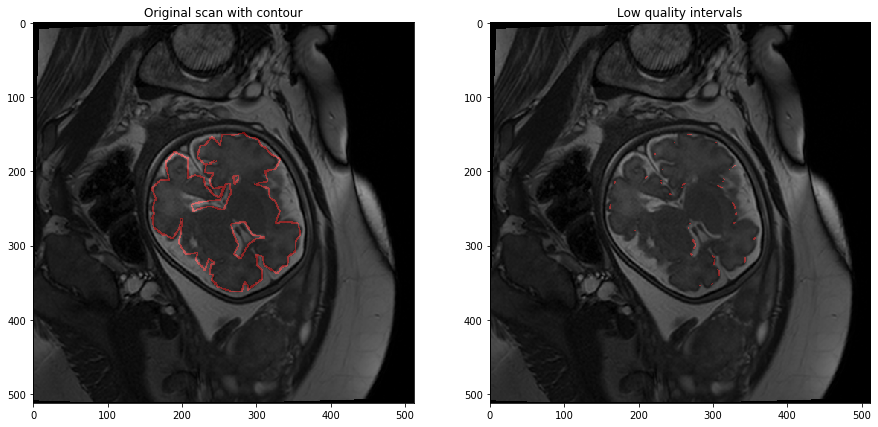

In [8]:
intervals, mask, SD = get_intervals(slice_normal, cont)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.title('Original scan with contour')
pil_im = overlay_image_mask(slice_normal, cont)
plt.imshow(np.asarray(pil_im))

plt.subplot(1,2,2)
plt.title('Low quality intervals')
pil_im = overlay_image_mask(slice_normal, mask)
plt.imshow(np.asarray(pil_im))

plt.show()

### Step 3 - Sensitivity Analysis 

For all segment $r_i ∈ R$ we compute the _Segment Direction_ $SD(r_i)$ and iteratively move the points of $r_i$ in the direction of $SD(r_i)$, as follows:
For each point in $r_i$ we compute the segment direction and update the coordinates, $x_i = x_i + t\cos(SD(r_i))$ and 
$y_i = y_i + t\sin(SD(r_i))$ for $0 < t < T_{length}$ if the _total segmentation quality_ of the updated segment is greater than $\epsilon$ we proceed to the next segment.

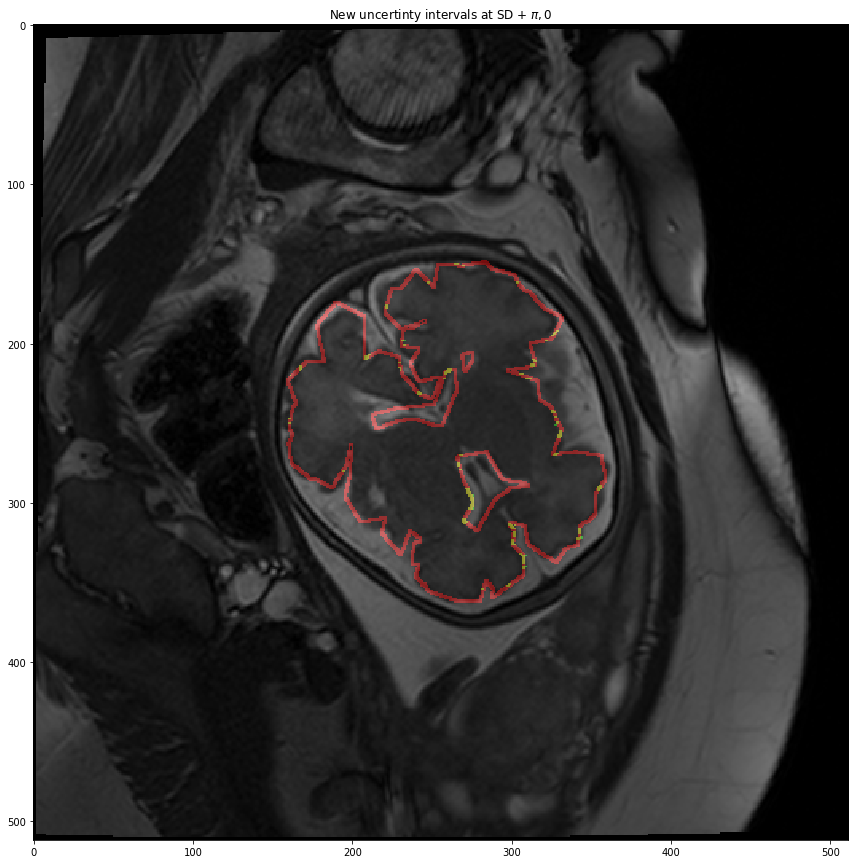

In [9]:
def get_segmentation_variability(img, contour):

    intervals, mask, direction = get_intervals(img, contour)

    new_seg = {}

    intensity_pr = intensity_prior(img, cont)
    TSPQ = np.sum(intensity_pr)
    
    dir_SD = [0, 0]


    new_seg['mask'] = cont.copy()
    new_seg['segments'] = np.zeros(img.shape)
    direction_lst = [0, np.pi]
    
    for d in direction_lst:    
        for i in range(len(intervals)):

            #print('segments' + str(count))
            curr_mask = cont.copy()
            segments = []
            y_tot = intervals[i][: , 0].copy()
            x_tot = intervals[i][: , 1].copy()

            curr_xy = (y_tot, x_tot)

            curr_mask[y_tot, x_tot] = 0 #This, for the computation of the new TSPQ


            for t in range(1,T_length):
                y_new = np.around(y_tot + t*ceil(sin(direction[i]+ d ))).astype(int)  
                x_new = np.around(x_tot + t*ceil(cos(direction[i]+ d ))).astype(int)
                curr_mask[y_new, x_new] = 1
                TSPQ_new = np.sum(intensity_prior(slice_normal, curr_mask))

                if abs(TSPQ-TSPQ_new)< eps:
                    curr_xy = (y_new, x_new)
                    continue 

                else:
                    y_final, x_final = curr_xy
                    segments.append(curr_xy)
                    new_seg['mask'][y_tot, x_tot] = 0
                    new_seg['mask'][y_final, x_final] = 1
                    new_seg['segments'][y_final, x_final] = 1
                    break
                    
    return new_seg

            

res_dict = get_segmentation_variability(slice_normal, cont)


plt.figure(figsize=(15,15))

plt.title('New uncertinty intervals at SD + $\pi,0$')
pil_im = overlay_image_mask(slice_normal,cont ,res_dict['segments'])
plt.imshow(np.asarray(pil_im))

plt.show()